First try of getting an Amplitude vs Time Graph.

While this does achieve a graph, I was mainly just trying to understand the terms and functions of how to deal with the graph, hence heavy the commenting.

In [ ]:
###import pathlib #find directory of a folder so that it works for other OSs
###import os #read the contents within folder
###------------### Only necessary when we do the searching for melody directory.


import pygame #start and stop of track playing
import scipy #has the fft <-- see OneNote page for explanation
#https://realpython.com/python-scipy-fft/
#http://www.differencebetween.net/technology/difference-between-fft-and-dft/

from scipy.io import wavfile


audio_to_identify = "C:\$$$AUDIO FILES\C3.wav"
rate, data = wavfile.read(audio_to_identify)
#mmap = False <-- file is not too large that it has to be mapped
# like any file, we have to read the information inside of it to do stuff with it.


#print(rate) #define rate: https://www.adobe.com/uk/creativecloud/video/discover/audio-sampling.html
#print(data) #define data: https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html
#data == the shape of the wave

##GETTING TO KNOW THE FUNCTIONS OF SCIPY TO DO WITH .WAV
print(f"number of channels = {data.shape[1]}")
length = data.shape[0] / rate #whole entire audio file/ the frequency of wave
print(f"length = {length}s")
print(data.shape[0])

##PLOTTING THE WAVE!!! -- Amplitude vs Time
import matplotlib.pyplot as plt
import numpy as np
time = np.linspace(0., length, data.shape[0])
plt.plot(time, data[:, 0], label="Left channel")
plt.plot(time, data[:, 1], label="Right channel") # Which speaker sound coming out of
plt.legend() # Where the key for the graph is
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

NORMALISATION -- important so sound can actually be heard. If amplitude/ power (power is the official term in programming for sound, but I use power and amplitude interchangeably as it means the same thing) is too small, then the tone will be harder to distinguish.

In [ ]:
##NORMALISATION

import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

in_wav = "C:\$$$AUDIO FILES\$$FULL_c3_major_scale.wav"
rate, data = wavfile.read(in_wav) 
##rate = data points per second
normalised_tone = np.int16((data[:,0]/data[:,0].max()) * 32767)
# This is the tone definition normalizes to 32k bits = standard height for the tone to be identified
# 32767 = 2^15 - 1, thus putting the .WAV file into the standard 16-bit height
# [:,0] is to get the data for one channel (speaker) because both channels will have similar data
# so it does not make sense to have data from both channels.
plt.plot(normalised_tone)
plt.xlabel("Point in Time")
plt.ylabel("Amplitude")
plt.ylim([-32767, 32767])
plt.show()
#Normalized tone will be used for further analysis

CREATING LIST OF ALL NOTES ON PIANO

Realistically, especially because the aim is to take human pitch and turn that into MIDI, the possible notes a human can reach are all going to be on a piano, and even then this is a very generous range.

In [ ]:
with open("C:\$$$AUDIO FILES\TO_USE-Note_To_MIDI_Table.csv") as f:
    formatted_all_notes = []
    all_notes = [line.split() for line in f]
    for lst in all_notes[1:]:
        for elem in lst:
            elem = elem.split(",")
            for i in range (1,4):
                if i == 1 or i == 3:
                    elem[i] = int(elem[i])
                else:
                    elem[i] = float(elem[i])
            formatted_all_notes.append(elem)
print(formatted_all_notes)

FIRST FORAY INTO RFFT

This is just a short note for why rfft is used in this code. For explanation of what it does (i.e. what is Fourier Transformation), please see OneNote.

rfft is used because:
(a) fft itself is quicker than dft
(b) rfft only takes values above zero -- sound is a sine curve so both positive and negative values are included
but in this case, not necessary because it is just a mirror image so dealing with positive numbers is ok.

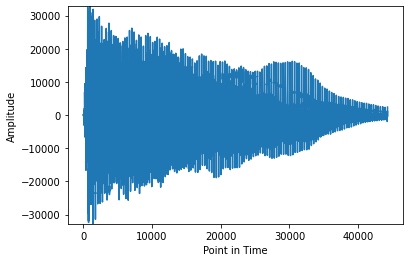

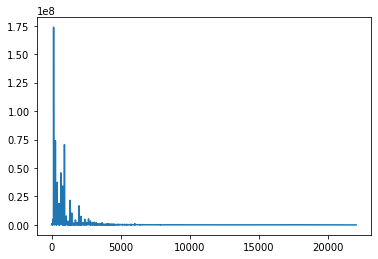

In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

from scipy.fft import rfft, rfftfreq #new!!!

in_wav = "C:\$$$AUDIO FILES\C3.wav"
rate, data = wavfile.read(in_wav) 
normalised_tone = np.int16((data[:,0]/data[:,0].max()) * 32767)
plt.plot(normalised_tone)
plt.xlabel("Point in Time")
plt.ylabel("Amplitude")
plt.ylim([-32767, 32767])
plt.show()


# ------------------------------ #
yf = rfft(normalised_tone) #calculates the transform itself
xf = rfftfreq(len(normalised_tone), 1 / rate) #calculates the frequencies in centre of each bin in output of fft

plt.plot(xf, np.abs(yf))
plt.show()

READING ONE TONE FROM WHOLE FILE -- PIANO

In [ ]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

from scipy.fft import rfft, rfftfreq

in_wav = "C:\$$$AUDIO FILES\C3.wav"

### STEP ONE: GET RID OF ONE CHANNEL IF ORIGINAL RECORDING HAS TWO SO EASIER TO DEAL WITH + NORMALISE FILE 
rate, data = wavfile.read(in_wav)
normalised_tone = np.int16((data[:,0]/data[:,0].max()) * 32767)

### STEP TWO: HOW TO GET TONE OF WHOLE FILE -- ONLY FOR ONE PITCH FILE

def single_pitch_to_MIDI(normalised_tone,rate):
    yf = rfft(normalised_tone) 
    xf = rfftfreq(len(normalised_tone),1/rate) 

    points_per_freq = len(xf) / (rate/2)
    # This is the number of points plotted per 1Hz of frequency.
    # The maximum frequency possibly reached is half the sample rate
    to_cut_off = int(points_per_freq * 4200) # Sets up point to cut sound off at 4200Hz because piano's highest key is 4186Hz

    yf = yf[:to_cut_off+1] # Cut off all points above 4200 Hz
    xf = xf[:to_cut_off+1]



    power = 0
    power_max = 0
    possible_tones = [['A0', 21, 27.5, 0], ['As0/Bb0', 22, 29.14, 0], ['B0', 23, 30.87, 0], ['C1', 24, 32.7, 0], ['Cs1/Db1', 25, 34.65, 0], ['D1', 26, 36.71, 0], ['Ds1/Eb1', 27, 38.89, 0], ['E1', 28, 41.2, 0], ['F1', 29, 43.65, 0], ['Fs1/Gb1', 30, 46.25, 0], ['G1', 31, 49.0, 0], ['Gs1/Ab1', 32, 51.91, 0], ['A1', 33, 55.0, 0], ['As1/Bb1', 34, 58.27, 0], ['B1', 35, 61.74, 0], ['C2', 36, 65.41, 0], ['Cs1/Db2', 37, 69.3, 0], ['D2', 38, 73.42, 0], ['Ds1/Eb2', 39, 77.78, 0], ['E2', 40, 82.41, 0], ['F2', 41, 87.31, 0], ['Fs1/Gb2', 42, 92.5, 0], ['G2', 43, 98.0, 0], ['Gs1/Ab2', 44, 103.83, 0], ['A2', 45, 110.0, 0], ['As1/Bb2', 46, 116.54, 0], ['B2', 47, 123.47, 0], ['C3', 48, 130.81, 0], ['Cs1/Db3', 49, 138.59, 0], ['D3', 50, 146.83, 0], ['Ds1/Eb3', 51, 155.56, 0], ['E3', 52, 164.81, 0], ['F3', 53, 174.61, 0], ['Fs1/Gb3', 54, 185.0, 0], ['G3', 55, 196.0, 0], ['Gs1/Ab3', 56, 207.65, 0], ['A3', 57, 220.0, 0], ['As1/Bb3', 58, 233.08, 0], ['B3', 59, 246.94, 0], ['C4', 60, 261.63, 0], ['Cs1/Db4', 61, 277.18, 0], ['D4', 62, 293.66, 0], ['Ds1/Eb4', 63, 311.13, 0], ['E4', 64, 329.63, 0], ['F4', 65, 349.23, 0], ['Fs1/Gb4', 66, 369.99, 0], ['G4', 67, 392.0, 0], ['Gs1/Ab4', 68, 415.3, 0], ['A4', 69, 440.0, 0], ['As1/Bb4', 70, 466.16, 0], ['B4', 71, 493.88, 0], ['C5', 72, 523.25, 0], ['Cs1/Db5', 73, 554.37, 0], ['D5', 74, 587.33, 0], ['Ds1/Eb5', 75, 622.25, 0], ['E5', 76, 659.26, 0], ['F5', 77, 698.46, 0], ['Fs1/Gb5', 78, 739.99, 0], ['G5', 79, 783.99, 0], ['Gs1/Ab5', 80, 830.61, 0], ['A5', 81, 880.0, 0], ['As1/Bb5', 82, 932.33, 0], ['B5', 83, 987.77, 0], ['C6', 84, 1046.5, 0], ['Cs1/Db6', 85, 1108.73, 0], ['D6', 86, 1174.66, 0], ['Ds1/Eb6', 87, 1244.51, 0], ['E6', 88, 1318.51, 0], ['F6', 89, 1396.91, 0], ['Fs1/Gb6', 90, 1479.98, 0], ['G6', 91, 1567.98, 0], ['Gs1/Ab6', 92, 1661.22, 0], ['A6', 93, 1760.0, 0], ['As1/Bb6', 94, 1864.66, 0], ['B6', 95, 1975.53, 0], ['C7', 96, 2093.0, 0], ['Cs1/Db7', 97, 2217.46, 0], ['D7', 98, 2349.32, 0], ['Ds1/Eb7', 99, 2489.02, 0], ['E7', 100, 2637.02, 0], ['F7', 101, 2793.83, 0], ['Fs1/Gb7', 102, 2959.96, 0], ['G7', 103, 3135.96, 0], ['Gs1/Ab7', 104, 3322.44, 0], ['A7', 105, 3520.0, 0], ['As1/Bb7', 106, 3729.31, 0], ['B7', 107, 3951.07, 0], ['C8', 108, 4186.01, 0]]
    # This is a VERY long list of all notes on Piano. While yes, I could have kept this in a .csv file or even put this into a dictionary,
    # I wanted to have it clearly written in front of me.
    # This also makes it easier to edit and/or change the list as necessary.
    # FORMAT OF LIST: [note, MIDI, frequency, amplitude]
    # Amplitude will change depending on what will be read from the .WAV file.


    for i in range(len(possible_tones)):
        f = possible_tones[i][2]
        # This is the frequency of the tone in the table.
        # Even though the sound from the file may not reach this perfect frequency, each MIDI's frequency is perfect, so
        # analysis of the sound needs to be done to find the most prominent perfect frequency.
        for j in range(to_cut_off-1):
            f_cur = xf[j] #point on graph x-axis to analyse
            f_front = xf[j+1] #one ahead of point f1
            if  (f_cur <= f < f_front):
                power = abs(abs(yf[j+1]) - abs(yf[j]))/(f_front-f_cur)+abs(yf[j])
                if power > power_max:
                    power_max = power
                possible_tones[i][3] = power
                break    
    # Method behind this:
    # Difference between power on the y-axis / Difference between two frequencies on x-axis + lower x-axis value
    # Absolute value necessary because we technically COULD come up with a negative answer due to how a sine wave looks like
    # but we do not want a negative value of frequency.
    # This is basically a glorified way of finding the average gradient between two points.
    ###---> See OneNote for more in-depth description


    p = len(possible_tones)
    for note in range(len(possible_tones)):
        if power_max != 0:
            possible_tones[note][3] = possible_tones[note][3]/power_max*100
            if possible_tones[note][3] <=10:
                # Tones less than 10 power/ amplitude are filtered out -- tone set to 1 as negligible sound.
                possible_tones[note][3] = 1
        else:
            possible_tones[note][3] = 1



    for note in possible_tones:
        if note[3] > 1: #finds the first tone with volume above 10
            actual_MIDI = note[1]
            break

    return actual_MIDI


single_pitch_to_MIDI(normalised_tone,rate)

It works!!!

READING TONE FROM ONE FILE -- HUMAN VOICE

In [ ]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

from scipy.fft import rfft, rfftfreq

in_wav = "C:\$$$AUDIO FILES\VOICE_C3.wav"

### STEP ONE: GET RID OF ONE CHANNEL IF ORIGINAL RECORDING HAS TWO SO EASIER TO DEAL WITH + NORMALISE FILE 
rate, data = wavfile.read(in_wav)
if data.ndim == 2: #data.ndim returns whether 1D or 2D list, i.e. 1 channel or 2 channels
    # Had to add this in because recording from phone is only one channel, while online recording is two.
    normalised_tone = np.int16((data[:,0]/data[:,0].max()) * 32767)
else:
    normalised_tone = np.int16((data[:]/data[:].max()) * 32767)

### STEP TWO: HOW TO GET TONE OF WHOLE FILE -- ONLY FOR ONE PITCH FILE

def single_pitch_to_MIDI(normalised_tone,rate):
    yf = rfft(normalised_tone) 
    xf = rfftfreq(len(normalised_tone),1/rate) 

    points_per_freq = len(xf) / (rate/2)
    to_cut_off = int(points_per_freq * 4200)

    yf = yf[:to_cut_off+1]
    xf = xf[:to_cut_off+1]
    
    power = 0
    power_max = 0
    possible_tones = [['A0', 21, 27.5, 0], ['As0/Bb0', 22, 29.14, 0], ['B0', 23, 30.87, 0], ['C1', 24, 32.7, 0], ['Cs1/Db1', 25, 34.65, 0], ['D1', 26, 36.71, 0], ['Ds1/Eb1', 27, 38.89, 0], ['E1', 28, 41.2, 0], ['F1', 29, 43.65, 0], ['Fs1/Gb1', 30, 46.25, 0], ['G1', 31, 49.0, 0], ['Gs1/Ab1', 32, 51.91, 0], ['A1', 33, 55.0, 0], ['As1/Bb1', 34, 58.27, 0], ['B1', 35, 61.74, 0], ['C2', 36, 65.41, 0], ['Cs1/Db2', 37, 69.3, 0], ['D2', 38, 73.42, 0], ['Ds1/Eb2', 39, 77.78, 0], ['E2', 40, 82.41, 0], ['F2', 41, 87.31, 0], ['Fs1/Gb2', 42, 92.5, 0], ['G2', 43, 98.0, 0], ['Gs1/Ab2', 44, 103.83, 0], ['A2', 45, 110.0, 0], ['As1/Bb2', 46, 116.54, 0], ['B2', 47, 123.47, 0], ['C3', 48, 130.81, 0], ['Cs1/Db3', 49, 138.59, 0], ['D3', 50, 146.83, 0], ['Ds1/Eb3', 51, 155.56, 0], ['E3', 52, 164.81, 0], ['F3', 53, 174.61, 0], ['Fs1/Gb3', 54, 185.0, 0], ['G3', 55, 196.0, 0], ['Gs1/Ab3', 56, 207.65, 0], ['A3', 57, 220.0, 0], ['As1/Bb3', 58, 233.08, 0], ['B3', 59, 246.94, 0], ['C4', 60, 261.63, 0], ['Cs1/Db4', 61, 277.18, 0], ['D4', 62, 293.66, 0], ['Ds1/Eb4', 63, 311.13, 0], ['E4', 64, 329.63, 0], ['F4', 65, 349.23, 0], ['Fs1/Gb4', 66, 369.99, 0], ['G4', 67, 392.0, 0], ['Gs1/Ab4', 68, 415.3, 0], ['A4', 69, 440.0, 0], ['As1/Bb4', 70, 466.16, 0], ['B4', 71, 493.88, 0], ['C5', 72, 523.25, 0], ['Cs1/Db5', 73, 554.37, 0], ['D5', 74, 587.33, 0], ['Ds1/Eb5', 75, 622.25, 0], ['E5', 76, 659.26, 0], ['F5', 77, 698.46, 0], ['Fs1/Gb5', 78, 739.99, 0], ['G5', 79, 783.99, 0], ['Gs1/Ab5', 80, 830.61, 0], ['A5', 81, 880.0, 0], ['As1/Bb5', 82, 932.33, 0], ['B5', 83, 987.77, 0], ['C6', 84, 1046.5, 0], ['Cs1/Db6', 85, 1108.73, 0], ['D6', 86, 1174.66, 0], ['Ds1/Eb6', 87, 1244.51, 0], ['E6', 88, 1318.51, 0], ['F6', 89, 1396.91, 0], ['Fs1/Gb6', 90, 1479.98, 0], ['G6', 91, 1567.98, 0], ['Gs1/Ab6', 92, 1661.22, 0], ['A6', 93, 1760.0, 0], ['As1/Bb6', 94, 1864.66, 0], ['B6', 95, 1975.53, 0], ['C7', 96, 2093.0, 0], ['Cs1/Db7', 97, 2217.46, 0], ['D7', 98, 2349.32, 0], ['Ds1/Eb7', 99, 2489.02, 0], ['E7', 100, 2637.02, 0], ['F7', 101, 2793.83, 0], ['Fs1/Gb7', 102, 2959.96, 0], ['G7', 103, 3135.96, 0], ['Gs1/Ab7', 104, 3322.44, 0], ['A7', 105, 3520.0, 0], ['As1/Bb7', 106, 3729.31, 0], ['B7', 107, 3951.07, 0], ['C8', 108, 4186.01, 0]]


    for i in range(len(possible_tones)):
        f = possible_tones[i][2]
        for j in range(to_cut_off-1):
            f_cur = xf[j]
            f_front = xf[j+1]
            if  (f_cur <= f < f_front):
                power = abs(abs(yf[j+1]) - abs(yf[j]))/(f_front-f_cur)+abs(yf[j])
                if power > power_max:
                    power_max = power
                possible_tones[i][3] = power
                break     

    p = len(possible_tones)
    for note in range(len(possible_tones)):
        if power_max != 0:
            possible_tones[note][3] = possible_tones[note][3]/power_max*100
            if possible_tones[note][3] <=10:
                possible_tones[note][3] = 1
        else:
            possible_tones[note][3] = 1



    for note in possible_tones:
        if note[3] > 1:
            actual_MIDI = note[1]
            break


    return actual_MIDI


single_pitch_to_MIDI(normalised_tone,rate)

FIRST RUN: This gives the wrong output for some reason... C3 = 48

UPDATE: I sang was a C4, not a C3 like I first thought... 
Therefore, output of MIDI value 60 is correct since C4 = 60
So, therefore the code works!!!
(I will leave the voice file as VOICE_C3.WAV to show my understanding journey. It does not matter the file is named incorrectly -- I will not be using it beyond this point.)

Onwards and upwards -- trying to get each individual MIDI from multiple different notes of the same .WAV file.

METHOD ONE:
1. Put silences in whole .WAV file.
2. Take these divided parts of the .WAV file and find what the MIDI is for this sample.

UPDATE ___20/02/2023___: I have now gotten three methods, each one more accurate than the last (see evaluation in OneNote).

FIRST STEP INTO FIRST METHOD:

This is just the same function above to format a smaller list of just:
possible_tones = [Note Name, MIDI value], ...

Simple function which takes MIDI value and turns it into note names so I do not need to keep looking at a MIDI-note name table so frequently.

In [2]:
with open("C:\$$$AUDIO FILES\ONLY_note_to_MIDI.csv") as f:
    formatted_all_notes = []
    all_notes = [line.split() for line in f]
    for lst in all_notes[1:]:
        for elem in lst:
            elem = elem.split(",")
            for i in range (1,4):
                if i == 1:
                    elem[i] = int(elem[i])
            formatted_all_notes.append(elem)
print(formatted_all_notes)

[['A0', 21], ['As0/Bb0', 22], ['B0', 23], ['C1', 24], ['Cs1/Db1', 25], ['D1', 26], ['Ds1/Eb1', 27], ['E1', 28], ['F1', 29], ['Fs1/Gb1', 30], ['G1', 31], ['Gs1/Ab1', 32], ['A1', 33], ['As1/Bb1', 34], ['B1', 35], ['C2', 36], ['Cs1/Db2', 37], ['D2', 38], ['Ds1/Eb2', 39], ['E2', 40], ['F2', 41], ['Fs1/Gb2', 42], ['G2', 43], ['Gs1/Ab2', 44], ['A2', 45], ['As1/Bb2', 46], ['B2', 47], ['C3', 48], ['Cs1/Db3', 49], ['D3', 50], ['Ds1/Eb3', 51], ['E3', 52], ['F3', 53], ['Fs1/Gb3', 54], ['G3', 55], ['Gs1/Ab3', 56], ['A3', 57], ['As1/Bb3', 58], ['B3', 59], ['C4', 60], ['Cs1/Db4', 61], ['D4', 62], ['Ds1/Eb4', 63], ['E4', 64], ['F4', 65], ['Fs1/Gb4', 66], ['G4', 67], ['Gs1/Ab4', 68], ['A4', 69], ['As1/Bb4', 70], ['B4', 71], ['C5', 72], ['Cs1/Db5', 73], ['D5', 74], ['Ds1/Eb5', 75], ['E5', 76], ['F5', 77], ['Fs1/Gb5', 78], ['G5', 79], ['Gs1/Ab5', 80], ['A5', 81], ['As1/Bb5', 82], ['B5', 83], ['C6', 84], ['Cs1/Db6', 85], ['D6', 86], ['Ds1/Eb6', 87], ['E6', 88], ['F6', 89], ['Fs1/Gb6', 90], ['G6', 91], ['

Now on to the main method!!!
Although the code below decidedly DOES work, on OneNote I have put one of my early drafts which I thought was going to work but did not. There, I have highlighted what I had to change completely (and where I spent hours looking at my code before I spotted a silly error).

In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

from scipy.fft import rfft, rfftfreq

in_wav = "C:\$$$AUDIO FILES\$$FULL_c3_major_scale.wav"


### ---------------------------------------------------------------------------------------------------- ###
### STEP ONE: GET RID OF ONE CHANNEL IF ORIGINAL RECORDING HAS TWO SO EASIER TO DEAL WITH + NORMALISE FILE 
rate, data = wavfile.read(in_wav)

normalised_tone = np.int16((data[:]/data[:].max()) * 32767)
# I am not using data[:,0] here because we want to normalise all the sound separately before getting data from one channel.
# This is because the overall volume from both channels is going to have a different volume than just one channel
# and each channel contributes a different volume sound at a different time, therefore it makes more sense to do it all together
# then separate it.

### ---------------------------------------------------------------------------------------------------- ###
### STEP TWO: Simple function which takes MIDI value and turns it into note names.
def midi_to_note_name(midi_value):
    possible_tones = [['A0', 21], ['As0/Bb0', 22], ['B0', 23], ['C1', 24], ['Cs1/Db1', 25], ['D1', 26], ['Ds1/Eb1', 27], ['E1', 28], ['F1', 29], ['Fs1/Gb1', 30], ['G1', 31], ['Gs1/Ab1', 32], ['A1', 33], ['As1/Bb1', 34], ['B1', 35], ['C2', 36], ['Cs1/Db2', 37], ['D2', 38], ['Ds1/Eb2', 39], ['E2', 40], ['F2', 41], ['Fs1/Gb2', 42], ['G2', 43], ['Gs1/Ab2', 44], ['A2', 45], ['As1/Bb2', 46], ['B2', 47], ['C3', 48], ['Cs1/Db3', 49], ['D3', 50], ['Ds1/Eb3', 51], ['E3', 52], ['F3', 53], ['Fs1/Gb3', 54], ['G3', 55], ['Gs1/Ab3', 56], ['A3', 57], ['As1/Bb3', 58], ['B3', 59], ['C4', 60], ['Cs1/Db4', 61], ['D4', 62], ['Ds1/Eb4', 63], ['E4', 64], ['F4', 65], ['Fs1/Gb4', 66], ['G4', 67], ['Gs1/Ab4', 68], ['A4', 69], ['As1/Bb4', 70], ['B4', 71], ['C5', 72], ['Cs1/Db5', 73], ['D5', 74], ['Ds1/Eb5', 75], ['E5', 76], ['F5', 77], ['Fs1/Gb5', 78], ['G5', 79], ['Gs1/Ab5', 80], ['A5', 81], ['As1/Bb5', 82], ['B5', 83], ['C6', 84], ['Cs1/Db6', 85], ['D6', 86], ['Ds1/Eb6', 87], ['E6', 88], ['F6', 89], ['Fs1/Gb6', 90], ['G6', 91], ['Gs1/Ab6', 92], ['A6', 93], ['As1/Bb6', 94], ['B6', 95], ['C7', 96], ['Cs1/Db7', 97], ['D7', 98], ['Ds1/Eb7', 99], ['E7', 100], ['F7', 101], ['Fs1/Gb7', 102], ['G7', 103], ['Gs1/Ab7', 104], ['A7', 105], ['As1/Bb7', 106], ['B7', 107], ['C8', 108]]
    midi_note_name = 0
    for tone in range(0,len(possible_tones)):
            if possible_tones[tone][1] == midi_value:
                midi_note_name = possible_tones[tone][0]
                return(midi_note_name)



### ---------------------------------------------------------------------------------------------------- ###
### STEP THREE: Bringing back original function for whole .WAV file to MIDI code
def single_pitch_to_MIDI(normalised_tone,rate):
    yf = rfft(normalised_tone) 
    xf = rfftfreq(len(normalised_tone),1/rate) 

    points_per_freq = len(xf) / (rate/2)
    to_cut_off = int(points_per_freq * 4200)

    yf = yf[:to_cut_off+1]
    xf = xf[:to_cut_off+1]
    
    power = 0
    power_max = 0
    possible_tones = [['A0', 21, 27.5, 0], ['As0/Bb0', 22, 29.14, 0], ['B0', 23, 30.87, 0], ['C1', 24, 32.7, 0], ['Cs1/Db1', 25, 34.65, 0], ['D1', 26, 36.71, 0], ['Ds1/Eb1', 27, 38.89, 0], ['E1', 28, 41.2, 0], ['F1', 29, 43.65, 0], ['Fs1/Gb1', 30, 46.25, 0], ['G1', 31, 49.0, 0], ['Gs1/Ab1', 32, 51.91, 0], ['A1', 33, 55.0, 0], ['As1/Bb1', 34, 58.27, 0], ['B1', 35, 61.74, 0], ['C2', 36, 65.41, 0], ['Cs1/Db2', 37, 69.3, 0], ['D2', 38, 73.42, 0], ['Ds1/Eb2', 39, 77.78, 0], ['E2', 40, 82.41, 0], ['F2', 41, 87.31, 0], ['Fs1/Gb2', 42, 92.5, 0], ['G2', 43, 98.0, 0], ['Gs1/Ab2', 44, 103.83, 0], ['A2', 45, 110.0, 0], ['As1/Bb2', 46, 116.54, 0], ['B2', 47, 123.47, 0], ['C3', 48, 130.81, 0], ['Cs1/Db3', 49, 138.59, 0], ['D3', 50, 146.83, 0], ['Ds1/Eb3', 51, 155.56, 0], ['E3', 52, 164.81, 0], ['F3', 53, 174.61, 0], ['Fs1/Gb3', 54, 185.0, 0], ['G3', 55, 196.0, 0], ['Gs1/Ab3', 56, 207.65, 0], ['A3', 57, 220.0, 0], ['As1/Bb3', 58, 233.08, 0], ['B3', 59, 246.94, 0], ['C4', 60, 261.63, 0], ['Cs1/Db4', 61, 277.18, 0], ['D4', 62, 293.66, 0], ['Ds1/Eb4', 63, 311.13, 0], ['E4', 64, 329.63, 0], ['F4', 65, 349.23, 0], ['Fs1/Gb4', 66, 369.99, 0], ['G4', 67, 392.0, 0], ['Gs1/Ab4', 68, 415.3, 0], ['A4', 69, 440.0, 0], ['As1/Bb4', 70, 466.16, 0], ['B4', 71, 493.88, 0], ['C5', 72, 523.25, 0], ['Cs1/Db5', 73, 554.37, 0], ['D5', 74, 587.33, 0], ['Ds1/Eb5', 75, 622.25, 0], ['E5', 76, 659.26, 0], ['F5', 77, 698.46, 0], ['Fs1/Gb5', 78, 739.99, 0], ['G5', 79, 783.99, 0], ['Gs1/Ab5', 80, 830.61, 0], ['A5', 81, 880.0, 0], ['As1/Bb5', 82, 932.33, 0], ['B5', 83, 987.77, 0], ['C6', 84, 1046.5, 0], ['Cs1/Db6', 85, 1108.73, 0], ['D6', 86, 1174.66, 0], ['Ds1/Eb6', 87, 1244.51, 0], ['E6', 88, 1318.51, 0], ['F6', 89, 1396.91, 0], ['Fs1/Gb6', 90, 1479.98, 0], ['G6', 91, 1567.98, 0], ['Gs1/Ab6', 92, 1661.22, 0], ['A6', 93, 1760.0, 0], ['As1/Bb6', 94, 1864.66, 0], ['B6', 95, 1975.53, 0], ['C7', 96, 2093.0, 0], ['Cs1/Db7', 97, 2217.46, 0], ['D7', 98, 2349.32, 0], ['Ds1/Eb7', 99, 2489.02, 0], ['E7', 100, 2637.02, 0], ['F7', 101, 2793.83, 0], ['Fs1/Gb7', 102, 2959.96, 0], ['G7', 103, 3135.96, 0], ['Gs1/Ab7', 104, 3322.44, 0], ['A7', 105, 3520.0, 0], ['As1/Bb7', 106, 3729.31, 0], ['B7', 107, 3951.07, 0], ['C8', 108, 4186.01, 0]]


    for i in range(len(possible_tones)):
        f = possible_tones[i][2]
        for j in range(to_cut_off-1):
            f_cur = xf[j]
            f_front = xf[j+1]
            if  (f_cur <= f < f_front):
                power = abs(abs(yf[j+1]) - abs(yf[j]))/(f_front-f_cur)+abs(yf[j])
                if power > power_max:
                    power_max = power
                possible_tones[i][3] = power
                break      

    p = len(possible_tones)
    for note in range(len(possible_tones)):
        if power_max != 0:
            possible_tones[note][3] = possible_tones[note][3]/power_max*100
            if possible_tones[note][3] <=10:
                possible_tones[note][3] = 1
        else:
            possible_tones[note][3] = 1



    for note in possible_tones:
        if note[3] > 1:
            actual_MIDI = note[1]
            break

    return actual_MIDI


### ---------------------------------------------------------------------------------------------------- ###
### STEP FOUR: Force silences
normalised_tone_prep_silence = [] # This will have all the silences put into it.
normalised_tone_edited = [] # This takes data from normalised_tone for one channel.

if data.ndim == 1:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i])
else:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i][0]) # Taking data from the left data channel.

        
for i in range (data.shape[0]):
    if abs(normalised_tone_edited[i]) < 1000:
        normalised_tone_prep_silence.append(0)
        # If point has power less than 1000, the point's power is taken to be 0 because it is negligible
        # in contrast to other points around it.
    else:
        normalised_tone_prep_silence.append(normalised_tone_edited[i])

### ---------------------------------------------------------------------------------------------------- ###
### STEP FIVE: Identifying samples from the forced silences.
bpm = 60 # beats per minute <-- easy to do 60 for now because one beat per minute.
normalised_tone_silences = []
normalised_tone_samples = []

counter = 0

# Now the file has silences built into it, we can start sampling it by these silences.
while counter < len(normalised_tone_prep_silence) - 101:
    if sum(normalised_tone_prep_silence[counter: (counter + 101)]) == 0:
        # Gap between samples have to be mroe than 100 points of 0 amplitude.
        # Keep in mind this is relatively short.
        # 100 points = 100/44100s = 0.002s (3.s.f) time
        # So as minimal data loss as possible.

        begin_silence = counter
        end_silence = counter
        counter += 100 # because we have already taken this section to be silent now.


        while (normalised_tone_prep_silence[counter] == 0) and (counter < len(normalised_tone_prep_silence)-1):
            counter += 1
            # This checks whether silence is greater than only 100 points.
        end_silence = counter
        normalised_tone_silences.append([begin_silence, end_silence])


        if len(normalised_tone_silences) >= 2:
                
                if abs(begin_silence - normalised_tone_silences[-2][1]) > (rate*60/bpm/4):
                    # EXPLANATION OF: rate*60/bpm/4
                    # This is the shortest possible tone which can be defined as a tone
                    # (number of points per second) * seconds per beat / beats per minute / 4
                    # (saying that a note has to be longer than semiquaver)
                    # One may see that 4 leaves a large area of error.
                    # This is just an arbitrary number for now -- this can be changed to be smaller.
                    normalised_tone_samples.append([normalised_tone_silences[-2][1],begin_silence])

                    
        else: # normlised_tone_silences[0][0] != 0
            if len(normalised_tone_silences) == 1:
                if (begin_silence) > (rate*60/bpm/4):
                    normalised_tone_samples.append([0,begin_silence])
            elif len(normalised_tone_silences) >= 2:
                if (begin_silence - normalised_tone_silences[-2][1]) > (rate*60/bpm/4): # same as above
                    normalised_tone_samples.append([normalised_tone_silences[-2][1],begin_silence])              

    counter += 1



all_midi_tones = [] # All MIDI notes for different samples
for i in range (len(normalised_tone_samples)):
    begin_sample = normalised_tone_samples[i][0]
    end_sample = normalised_tone_samples[i][1]

    if (end_sample - begin_sample) > (rate*60/bpm/4):
        midi_of_sample = single_pitch_to_MIDI(normalised_tone_prep_silence[begin_sample : end_sample + 1], rate)
        duration_of_sample = (end_sample - begin_sample)/rate
        all_midi_tones.append([midi_to_note_name(midi_of_sample),midi_of_sample,duration_of_sample,bpm,100])


for i in range (len(all_midi_tones)):
    print(all_midi_tones[i])

['C3', 48, 0.9407256235827665, 60, 100]
['D3', 50, 0.9956689342403628, 60, 100]
['E3', 52, 0.9913151927437641, 60, 100]
['F3', 53, 0.9333106575963719, 60, 100]
['G3', 55, 0.923968253968254, 60, 100]
['A3', 57, 0.8589795918367347, 60, 100]
['B3', 59, 0.943015873015873, 60, 100]
['C4', 60, 0.8227437641723356, 60, 100]


Now this method works because of how a piano decays, but the aim is to take human voice and see if that works.
Silences will not happen in the human voice as much, so I thought of another method.

METHODOLOGY TWO:

With a predefined Beats Per Minute, we can take each sample to be the time between each beat per minute rather than silences between notes.

In [ ]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

from scipy.fft import rfft, rfftfreq

in_wav = "C:\$$$AUDIO FILES\$FULL_c4_major_scale_piano.wav"


### ------------------------------------------------------------------------------------------------------------------- ###
### STEP ONE: GET RID OF ONE CHANNEL IF ORIGINAL RECORDING HAS TWO SO EASIER TO DEAL WITH + NORMALISE FILE 
rate, data = wavfile.read(in_wav)

normalised_tone = np.int16((data[:]/data[:].max()) * 32767)

### ------------------------------------------------------------------------------------------------------------------- ###
### STEP TWO: Simple function which takes MIDI value and turns it into note names.
def midi_to_note_name(midi_value):
    possible_tones = [['A0', 21], ['As0/Bb0', 22], ['B0', 23], ['C1', 24], ['Cs1/Db1', 25], ['D1', 26], ['Ds1/Eb1', 27], ['E1', 28], ['F1', 29], ['Fs1/Gb1', 30], ['G1', 31], ['Gs1/Ab1', 32], ['A1', 33], ['As1/Bb1', 34], ['B1', 35], ['C2', 36], ['Cs1/Db2', 37], ['D2', 38], ['Ds1/Eb2', 39], ['E2', 40], ['F2', 41], ['Fs1/Gb2', 42], ['G2', 43], ['Gs1/Ab2', 44], ['A2', 45], ['As1/Bb2', 46], ['B2', 47], ['C3', 48], ['Cs1/Db3', 49], ['D3', 50], ['Ds1/Eb3', 51], ['E3', 52], ['F3', 53], ['Fs1/Gb3', 54], ['G3', 55], ['Gs1/Ab3', 56], ['A3', 57], ['As1/Bb3', 58], ['B3', 59], ['C4', 60], ['Cs1/Db4', 61], ['D4', 62], ['Ds1/Eb4', 63], ['E4', 64], ['F4', 65], ['Fs1/Gb4', 66], ['G4', 67], ['Gs1/Ab4', 68], ['A4', 69], ['As1/Bb4', 70], ['B4', 71], ['C5', 72], ['Cs1/Db5', 73], ['D5', 74], ['Ds1/Eb5', 75], ['E5', 76], ['F5', 77], ['Fs1/Gb5', 78], ['G5', 79], ['Gs1/Ab5', 80], ['A5', 81], ['As1/Bb5', 82], ['B5', 83], ['C6', 84], ['Cs1/Db6', 85], ['D6', 86], ['Ds1/Eb6', 87], ['E6', 88], ['F6', 89], ['Fs1/Gb6', 90], ['G6', 91], ['Gs1/Ab6', 92], ['A6', 93], ['As1/Bb6', 94], ['B6', 95], ['C7', 96], ['Cs1/Db7', 97], ['D7', 98], ['Ds1/Eb7', 99], ['E7', 100], ['F7', 101], ['Fs1/Gb7', 102], ['G7', 103], ['Gs1/Ab7', 104], ['A7', 105], ['As1/Bb7', 106], ['B7', 107], ['C8', 108]]
    midi_note_name = 0
    for tone in range(0,len(possible_tones)):
            if possible_tones[tone][1] == midi_value:
                midi_note_name = possible_tones[tone][0]
                return(midi_note_name)



### ------------------------------------------------------------------------------------------------------------------- ###
### STEP THREE: Bringing back original function for whole .WAV file to MIDI code
def single_pitch_to_MIDI(normalised_tone,rate):
    yf = rfft(normalised_tone) 
    xf = rfftfreq(len(normalised_tone),1/rate) 

    points_per_freq = len(xf) / (rate/2)
    to_cut_off = int(points_per_freq * 4200)

    yf = yf[:to_cut_off+1]
    xf = xf[:to_cut_off+1]
    
    power = 0
    power_max = 0
    possible_tones = [['A0', 21, 27.5, 0], ['As0/Bb0', 22, 29.14, 0], ['B0', 23, 30.87, 0], ['C1', 24, 32.7, 0], ['Cs1/Db1', 25, 34.65, 0], ['D1', 26, 36.71, 0], ['Ds1/Eb1', 27, 38.89, 0], ['E1', 28, 41.2, 0], ['F1', 29, 43.65, 0], ['Fs1/Gb1', 30, 46.25, 0], ['G1', 31, 49.0, 0], ['Gs1/Ab1', 32, 51.91, 0], ['A1', 33, 55.0, 0], ['As1/Bb1', 34, 58.27, 0], ['B1', 35, 61.74, 0], ['C2', 36, 65.41, 0], ['Cs1/Db2', 37, 69.3, 0], ['D2', 38, 73.42, 0], ['Ds1/Eb2', 39, 77.78, 0], ['E2', 40, 82.41, 0], ['F2', 41, 87.31, 0], ['Fs1/Gb2', 42, 92.5, 0], ['G2', 43, 98.0, 0], ['Gs1/Ab2', 44, 103.83, 0], ['A2', 45, 110.0, 0], ['As1/Bb2', 46, 116.54, 0], ['B2', 47, 123.47, 0], ['C3', 48, 130.81, 0], ['Cs1/Db3', 49, 138.59, 0], ['D3', 50, 146.83, 0], ['Ds1/Eb3', 51, 155.56, 0], ['E3', 52, 164.81, 0], ['F3', 53, 174.61, 0], ['Fs1/Gb3', 54, 185.0, 0], ['G3', 55, 196.0, 0], ['Gs1/Ab3', 56, 207.65, 0], ['A3', 57, 220.0, 0], ['As1/Bb3', 58, 233.08, 0], ['B3', 59, 246.94, 0], ['C4', 60, 261.63, 0], ['Cs1/Db4', 61, 277.18, 0], ['D4', 62, 293.66, 0], ['Ds1/Eb4', 63, 311.13, 0], ['E4', 64, 329.63, 0], ['F4', 65, 349.23, 0], ['Fs1/Gb4', 66, 369.99, 0], ['G4', 67, 392.0, 0], ['Gs1/Ab4', 68, 415.3, 0], ['A4', 69, 440.0, 0], ['As1/Bb4', 70, 466.16, 0], ['B4', 71, 493.88, 0], ['C5', 72, 523.25, 0], ['Cs1/Db5', 73, 554.37, 0], ['D5', 74, 587.33, 0], ['Ds1/Eb5', 75, 622.25, 0], ['E5', 76, 659.26, 0], ['F5', 77, 698.46, 0], ['Fs1/Gb5', 78, 739.99, 0], ['G5', 79, 783.99, 0], ['Gs1/Ab5', 80, 830.61, 0], ['A5', 81, 880.0, 0], ['As1/Bb5', 82, 932.33, 0], ['B5', 83, 987.77, 0], ['C6', 84, 1046.5, 0], ['Cs1/Db6', 85, 1108.73, 0], ['D6', 86, 1174.66, 0], ['Ds1/Eb6', 87, 1244.51, 0], ['E6', 88, 1318.51, 0], ['F6', 89, 1396.91, 0], ['Fs1/Gb6', 90, 1479.98, 0], ['G6', 91, 1567.98, 0], ['Gs1/Ab6', 92, 1661.22, 0], ['A6', 93, 1760.0, 0], ['As1/Bb6', 94, 1864.66, 0], ['B6', 95, 1975.53, 0], ['C7', 96, 2093.0, 0], ['Cs1/Db7', 97, 2217.46, 0], ['D7', 98, 2349.32, 0], ['Ds1/Eb7', 99, 2489.02, 0], ['E7', 100, 2637.02, 0], ['F7', 101, 2793.83, 0], ['Fs1/Gb7', 102, 2959.96, 0], ['G7', 103, 3135.96, 0], ['Gs1/Ab7', 104, 3322.44, 0], ['A7', 105, 3520.0, 0], ['As1/Bb7', 106, 3729.31, 0], ['B7', 107, 3951.07, 0], ['C8', 108, 4186.01, 0]]


    for i in range(len(possible_tones)):
        f = possible_tones[i][2]
        for j in range(to_cut_off-1):
            f_cur = xf[j]
            f_front = xf[j+1]
            if  (f_cur <= f < f_front):
                power = abs(abs(yf[j+1]) - abs(yf[j]))/(f_front-f_cur)+abs(yf[j])
                if power > power_max:
                    power_max = power
                possible_tones[i][3] = power
                break     

    p = len(possible_tones)
    for note in range(len(possible_tones)):
        if power_max != 0:
            possible_tones[note][3] = possible_tones[note][3]/power_max*100
            if possible_tones[note][3] <=10:
                possible_tones[note][3] = 1
        else:
            possible_tones[note][3] = 1



    for note in possible_tones:
        if note[3] > 1:
            actual_MIDI = note[1]
            break
    
    return actual_MIDI


### ------------------------------------------------------------------------------------------------------------------- ###
### STEP FOUR: Force silences -- I still want to keep this because, even though not necessary, it is still good to have
normalised_tone_prep_silence = []
normalised_tone_edited = []

if data.ndim == 1:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i])
else:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i][0])

        
for i in range (data.shape[0]):
    if abs(normalised_tone_edited[i]) < 1000:
        normalised_tone_prep_silence.append(0)
    else:
        normalised_tone_prep_silence.append(normalised_tone_edited[i])

### ---------------------------------------------------------------------------------------------------- ###
### STEP FIVE: Identifying samples from the forced silences.
normalised_time_silences = []
normalised_time_samples = []
bpm = 60 # Once again, just an arbitrary number.
idx = 0

while normalised_tone_prep_silence[idx]==0:
    idx = idx + 1
start_track = idx # There is usually silence at beginning of track so this says where the tracks proper sound begins.
idx = len(normalised_tone_prep_silence) -1
while normalised_tone_prep_silence[idx] == 0:
    idx = idx - 1
end_track = idx # This filters out sound at end of track.

number_of_beats = int((end_track-start_track)/rate*bpm/60) + 1
# This is the integer number of beats in the track.
# + 1 is there because, if there is not a whole number of beats before the int function, the fractional part of the number of beats,
# which needs to be analysed as there is sound, will not be analysed.

all_midi_by_beat = []



for i in range(number_of_beats):
    begin_sample = int(start_track + (i * rate * 60/bpm))
    # int(the start of the track's proper sound + how many beats along the track should be)
    # integer so it can be used to slice normalised_tone_prep_silence later on.
    end_sample = min((int(start_track+(i+1)*rate*60/bpm), end_track))
    # this creates the end of the sample as either the next beat along or the end of the track, hence the min() function.

    if (end_sample - begin_sample) >(rate*60/bpm/4):
        midi_of_sample = single_pitch_to_MIDI(normalised_tone_prep_silence[begin_sample:end_sample+1],rate)
        duration_of_sample = 60/bpm
        all_midi_by_beat.append([midi_to_note_name(midi_of_sample),midi_of_sample,duration_of_sample,bpm,100])

for i in range(0,len(all_midi_by_beat)):
    print(all_midi_by_beat[i])

This output, while it may avoid the issue that occurs with Method 1, it still will not be that precise if there is any semblance of syncopation across the beat. Therefore, I have developed a final methodology before I go on to presenting and using my sound_to_MIDI code.

___METHOD THREE:___
1. Cut the start and end of the .WAV file of silences before splitting the file into 0.01s samples.
2. Run FFT on the sample.
3. Identify top 6 frequency values (arbitrary value -- can be any number, but more than three is good) with the highest FFT value (i.e. power) in that sample.
6. Run single_pitch_to_midi function and return MIDI of the 6 frequency.
7. Look for the lowest MIDI out of the top 6 frequency 
(if one makes a graph out of all the points, one will see there are random harmonics for some of these 0.01s points)
8. Append this value to the list.
9. Find min of points in a 15 points either side of point examined range (if point at beginning or end 15, just analyse first 15 and last 15 points).
10. Append MIDI value to database.
11. Check if MIDI is the same length as previous MIDI. If yes, put length together with previous length of same note.
12. Work out BPM.
14. Edit out unrealistic short tones.

In [3]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import math

from scipy.fft import rfft, rfftfreq

in_wav = "C:\$$$AUDIO FILES\$$FULL_c3_major_scale.wav"


### ------------------------------------------------------------------------------------------------------------------- ###
### STEP ONE: GET RID OF ONE CHANNEL IF ORIGINAL RECORDING HAS TWO SO EASIER TO DEAL WITH + NORMALISE FILE 
rate, data = wavfile.read(in_wav)

normalised_tone = np.int16((data[:]/data[:].max()) * 32767)

### ------------------------------------------------------------------------------------------------------------------- ###
### STEP TWO: Simple function which takes MIDI value and turns it into note names.
def midi_to_note_name(midi_value):
    possible_tones = [['A0', 21], ['As0/Bb0', 22], ['B0', 23], ['C1', 24], ['Cs1/Db1', 25], ['D1', 26], ['Ds1/Eb1', 27], ['E1', 28], ['F1', 29], ['Fs1/Gb1', 30], ['G1', 31], ['Gs1/Ab1', 32], ['A1', 33], ['As1/Bb1', 34], ['B1', 35], ['C2', 36], ['Cs1/Db2', 37], ['D2', 38], ['Ds1/Eb2', 39], ['E2', 40], ['F2', 41], ['Fs1/Gb2', 42], ['G2', 43], ['Gs1/Ab2', 44], ['A2', 45], ['As1/Bb2', 46], ['B2', 47], ['C3', 48], ['Cs1/Db3', 49], ['D3', 50], ['Ds1/Eb3', 51], ['E3', 52], ['F3', 53], ['Fs1/Gb3', 54], ['G3', 55], ['Gs1/Ab3', 56], ['A3', 57], ['As1/Bb3', 58], ['B3', 59], ['C4', 60], ['Cs1/Db4', 61], ['D4', 62], ['Ds1/Eb4', 63], ['E4', 64], ['F4', 65], ['Fs1/Gb4', 66], ['G4', 67], ['Gs1/Ab4', 68], ['A4', 69], ['As1/Bb4', 70], ['B4', 71], ['C5', 72], ['Cs1/Db5', 73], ['D5', 74], ['Ds1/Eb5', 75], ['E5', 76], ['F5', 77], ['Fs1/Gb5', 78], ['G5', 79], ['Gs1/Ab5', 80], ['A5', 81], ['As1/Bb5', 82], ['B5', 83], ['C6', 84], ['Cs1/Db6', 85], ['D6', 86], ['Ds1/Eb6', 87], ['E6', 88], ['F6', 89], ['Fs1/Gb6', 90], ['G6', 91], ['Gs1/Ab6', 92], ['A6', 93], ['As1/Bb6', 94], ['B6', 95], ['C7', 96], ['Cs1/Db7', 97], ['D7', 98], ['Ds1/Eb7', 99], ['E7', 100], ['F7', 101], ['Fs1/Gb7', 102], ['G7', 103], ['Gs1/Ab7', 104], ['A7', 105], ['As1/Bb7', 106], ['B7', 107], ['C8', 108]]
    midi_note_name = 0
    for tone in range(0,len(possible_tones)):
            if possible_tones[tone][1] == midi_value:
                midi_note_name = possible_tones[tone][0]
                return(midi_note_name)



### ------------------------------------------------------------------------------------------------------------------- ###
### STEP FOUR: Force silences -- I still want to keep this because, even though not necessary, it is still good to have.
###            this also gets rid of silences at beginning and end
normalised_tone_prep_silence = []
normalised_tone_edited = []

if data.ndim == 1:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i])
else:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i][0])

        
for i in range (data.shape[0]):
    if abs(normalised_tone_edited[i]) < 1000:
        normalised_tone_prep_silence.append(0)
    else:
        normalised_tone_prep_silence.append(normalised_tone_edited[i])

idx = 0
while normalised_tone_prep_silence[idx]==0:
    idx = idx + 1
start_track = idx
idx = len(normalised_tone_prep_silence) - 1
while normalised_tone_prep_silence[idx] == 0:
    idx = idx - 1
end_track = idx # This filters out sound at end of track.

### ---------------------------------------------------------------------------------------------------- ###
### STEP FIVE: This function returns the MIDI of the six sample data points

def multiple_midi_from_sample(data, begin_sample, length_sample_points):
    
    end_sample = begin_sample + length_sample_points
    data_of_sample = data[begin_sample: end_sample]
    normalised_tone = data_of_sample

    num_points_freq = end_sample - begin_sample

    
    yf = rfft(normalised_tone) #Rapid Fourier transformation on Normalized Tone - returns Aplitude for each frequency
    xf = rfftfreq(num_points_freq, 1 / rate)
    k = min(len(xf),len(yf))
    # This is just to make sure both data sets are the same length -- really confusingly, sometimes yf is shorter than xf.

    xf = xf[:k]
    yf = yf[:k]
    # plt.plot(xf, np.abs(yf))
    # plt.xlabel("Frequencies in the Wave Sample in Hz")
    # plt.ylabel("FFT Amplitude of given Frequency")
    # plt.xlim([0,4000]) #plot frequency from 0 to 4000 Hz
    # plt.show()
    # The maximum detectable frequency is half the sample rate (44100 sample rate can determine frequency up to 22kHz (ie. maximum hearing range)

    power_a = 0
    point_a = 0
    power_b = 0
    point_b = 0
    power_c = 0
    point_c = 0
    power_d = 0
    point_d = 0
    power_e = 0
    point_e = 0
    power_f = 0
    point_f = 0
    

    for i in range(len(xf)):
        # EXPLANATION OF IF STATEMENTS:
        # if current power > highest power:
            # highest power = current power
            # where maximum point is
            
        if yf[i] > power_a:
            power_a = yf[i]
            point_a = i
        elif yf[i] > power_b:
            power_b = yf[i]
            point_b = i
        elif yf[i] > power_c:
            power_c = yf[i]
            point_c = i
        elif yf[i] > power_d:
            power_d = yf[i]
            point_d = i
        elif yf[i] > power_e:
            power_e = yf[i]
            point_e = i
        elif yf[i] > power_f:
            power_f = yf[i]
            point_f = i

    freq_a = xf[point_a]
    freq_b = xf[point_b]
    freq_c = xf[point_c]
    freq_d = xf[point_d]
    freq_e = xf[point_e]
    freq_f = xf[point_f]

    midi_freq_a = 0 # set this to 0 in case the frequency is not greater than 0.
    midi_freq_b = 0
    midi_freq_c = 0
    midi_freq_d = 0
    midi_freq_e = 0
    midi_freq_f = 0
    
    if freq_a > 10:  # Minimum must be at least 10 Hz
        midi_freq_a =  int(round((12*math.log2(freq_a/440) + 69),0))
        # This line is based off the note A4, the normal tuning note for an orchestra.
        # This function is more of a standard thing found:
        # https://en.wikipedia.org/wiki/Piano_key_frequencies
        # rather than something I came up with.
    if freq_b > 10:  # Minimum must be at least 10 Hz
        midi_freq_b =  int(round((12*math.log2(freq_b/440) + 69),0))
    if freq_c > 10:
        midi_freq_c =  int(round((12*math.log2(freq_c/440) + 69),0))
    if freq_d > 10:
        midi_freq_d =  int(round((12*math.log2(freq_d/440) + 69),0))
    if freq_e > 10:
        midi_freq_e =  int(round((12*math.log2(freq_e/440) + 69),0))
    if freq_f > 10:
        midi_freq_f =  int(round((12*math.log2(freq_f/440) + 69),0))
        

    return (midi_freq_a,midi_freq_b,midi_freq_c,midi_freq_d,midi_freq_e,midi_freq_f)
    # It is ok for this to be returned as a tuple as I will not be editing it.
### ---------------------------------------------------------------------------------------------------- ###
### STEP SIX: Analysing top six tones of 0.01s samples, finding minimum MIDI and putting length of notes in.

bpm = 60
points_to_run_analysis = int(rate/100)
# rate = 44100 (usually) / 100 
# This is because each 441 points is 0.01s, thus this tells us how many samples are going to be formed

midi_sound_a = [] # This is the output file for MIDI notes
midi_sound_b = []
midi_sound_c = []
midi_sound_d = []
midi_sound_e = []


for begin_sample in range(0,len(normalised_tone_prep_silence),points_to_run_analysis):
    # begin_sample is the beginning point of the sample to be taken.
    midi_tone = multiple_midi_from_sample(normalised_tone_prep_silence, begin_sample, int(60/bpm*rate))
    # midi_tone is a tuple of the top six most powerful MIDI tones.
    # int(60/bpm*rate) = how many data points should be in sample, i.e. what number should be added to begin_sample.

    midi_sound_a.append(midi_tone) # All top 6 power MIDI values of samples are all appended to midi_sound_a.


# This finds out the minimum MIDI value of top six most powerful MIDI tones.
for i in range(len(midi_sound_a)):
    min_midi = 108 # This is the top value of MIDI we can possibly have. Everything else will be lower.
    for j in range(6):
        if midi_sound_a[i][j] < min_midi:
            min_midi = midi_sound_a[i][j]
    midi_sound_b.append(min_midi) # All min MIDI value of each sample in midi_sound_b.

# Trying to select minimum MIDI value in 0.03s interval -- to further get rid of rogue harmonics.
width_of_search = 15 # Width of search for minimum MIDI.
for i in range (len(midi_sound_b)):
    if i < width_of_search:
        midi_sound_c.append(min(midi_sound_b[:width_of_search]))
    elif width_of_search <= i < len(midi_sound_b) - width_of_search:
        midi_sound_c.append(min(midi_sound_b[(i - width_of_search):(i + width_of_search)]))
    elif i >= len(midi_sound_b) - width_of_search:
        midi_sound_c.append(min(midi_sound_b[(len(midi_sound_b) - width_of_search):]))

# Now checking if sample is the same as a previous sample and joining these together to create one note.
# While these sampes may be distinct notes even though they are of the same pitch, this code cannot tell.
# Therefore, I need to think of a good way to circumvent this.
counter_midi_sound_d = 0
midi_sound_d.append([midi_sound_c[0],0.01]) # Append MIDI note and sample length

for i in range(1,len(midi_sound_c)):
    if midi_sound_c[i] == midi_sound_d[-1][0]:
        midi_sound_d[-1][1] += 0.01
    else:
        midi_sound_d.append([midi_sound_c[i],0.01])


final_bpm = 60/(len(normalised_tone_prep_silence)/ len(midi_sound_d))
midi_sound_d_final = []

# This checks the notes are longer than a required length.
for tone in midi_sound_d:
    if tone[0] > 0 and tone[1] > 0.1:
        # The tone has to be longer than 0.1.
        # For context, 300bpm is 0.2s per beat, so the note being longer than 0.1 is generous
        # because the notes have to be within the realm of possibility of singing.
        midi_sound_d_final.append([midi_to_note_name(tone[0]), tone[0], tone[1],final_bpm, 100]) # 100 is maximum volume.
    else:
        if len(midi_sound_d_final) > 0:
            if tone[0] == midi_sound_d_final[-1][1]:
                midi_sound_d_final[-1][2] += tone[1]
                # i.e. If note is too short, add time of current note to the previous note if MIDI is the same.


for tone in midi_sound_d_final:
    print(tone)

# Forcing the notes to bpm = 60/ whatever bpm it is given. This will get rid of rogue very short notes which might have been sung by accident.
for i in range (len(midi_sound_d_final)):
    duration_of_tone = midi_sound_d_final[i][2]
    if (0.35*(60/bpm) <= duration_of_tone <= (1.5*(60/bpm))) and (midi_sound_d_final[i][1] > 20):
        #1.5 or 0.35 are important factors for note duration; M = 20 is minimum midi tone
        duration_of_tone = 60/bpm # force 1 beat time
        midi_sound_e.append([midi_to_note_name(midi_sound_d_final[i][1]), midi_sound_d_final[i][1], duration_of_tone , bpm, 100])

print("-----")
for i in range (len(midi_sound_e)):
    print(midi_sound_e[i])

['C3', 48, 1.0400000000000007, 0.0013673032222779272, 100]
['D3', 50, 1.2300000000000009, 0.0013673032222779272, 100]
['E3', 52, 0.9500000000000006, 0.0013673032222779272, 100]
['F3', 53, 0.5300000000000002, 0.0013673032222779272, 100]
['G3', 55, 1.2500000000000009, 0.0013673032222779272, 100]
['A3', 57, 1.0300000000000007, 0.0013673032222779272, 100]
['As1/Bb3', 58, 0.17, 0.0013673032222779272, 100]
['B3', 59, 1.0000000000000007, 0.0013673032222779272, 100]
['C4', 60, 0.9000000000000006, 0.0013673032222779272, 100]
-----
['C3', 48, 1.0, 60, 100]
['D3', 50, 1.0, 60, 100]
['E3', 52, 1.0, 60, 100]
['F3', 53, 1.0, 60, 100]
['G3', 55, 1.0, 60, 100]
['A3', 57, 1.0, 60, 100]
['B3', 59, 1.0, 60, 100]
['C4', 60, 1.0, 60, 100]


Problem here -- if a note was too short for the BPM, then it would not pick it up despite it being the desired note.
Thus I have changed the if statement in line 236 to the one in line 237.

Therefore -- we have a final code (at least for the purpose I want it to serve!!!).

In [11]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import math

from scipy.fft import rfft, rfftfreq

from midiutil import MIDIFile
import pretty_midi
import librosa
import mir_eval.display
import librosa.display

# in_wav = "C:\$$$AUDIO FILES\VOICE_C4_Scale.wav"
in_wav = "C:\$$$AUDIO FILES\VOICE_C4_Scale_2.wav"
# in_wav = "C:\$$$AUDIO FILES\VOICE_C4_Scale_3.wav"


### ------------------------------------------------------------------------------------------------------------------- ###
### STEP ONE: GET RID OF ONE CHANNEL IF ORIGINAL RECORDING HAS TWO SO EASIER TO DEAL WITH + NORMALISE FILE 
rate, data = wavfile.read(in_wav)

normalised_tone = np.int16((data[:]/data[:].max()) * 32767)

### ------------------------------------------------------------------------------------------------------------------- ###
### STEP TWO: Simple function which takes MIDI value and turns it into note names.
def midi_to_note_name(midi_value):
    possible_tones = [['A0', 21], ['As0/Bb0', 22], ['B0', 23], ['C1', 24], ['Cs1/Db1', 25], ['D1', 26], ['Ds1/Eb1', 27], ['E1', 28], ['F1', 29], ['Fs1/Gb1', 30], ['G1', 31], ['Gs1/Ab1', 32], ['A1', 33], ['As1/Bb1', 34], ['B1', 35], ['C2', 36], ['Cs1/Db2', 37], ['D2', 38], ['Ds1/Eb2', 39], ['E2', 40], ['F2', 41], ['Fs1/Gb2', 42], ['G2', 43], ['Gs1/Ab2', 44], ['A2', 45], ['As1/Bb2', 46], ['B2', 47], ['C3', 48], ['Cs1/Db3', 49], ['D3', 50], ['Ds1/Eb3', 51], ['E3', 52], ['F3', 53], ['Fs1/Gb3', 54], ['G3', 55], ['Gs1/Ab3', 56], ['A3', 57], ['As1/Bb3', 58], ['B3', 59], ['C4', 60], ['Cs1/Db4', 61], ['D4', 62], ['Ds1/Eb4', 63], ['E4', 64], ['F4', 65], ['Fs1/Gb4', 66], ['G4', 67], ['Gs1/Ab4', 68], ['A4', 69], ['As1/Bb4', 70], ['B4', 71], ['C5', 72], ['Cs1/Db5', 73], ['D5', 74], ['Ds1/Eb5', 75], ['E5', 76], ['F5', 77], ['Fs1/Gb5', 78], ['G5', 79], ['Gs1/Ab5', 80], ['A5', 81], ['As1/Bb5', 82], ['B5', 83], ['C6', 84], ['Cs1/Db6', 85], ['D6', 86], ['Ds1/Eb6', 87], ['E6', 88], ['F6', 89], ['Fs1/Gb6', 90], ['G6', 91], ['Gs1/Ab6', 92], ['A6', 93], ['As1/Bb6', 94], ['B6', 95], ['C7', 96], ['Cs1/Db7', 97], ['D7', 98], ['Ds1/Eb7', 99], ['E7', 100], ['F7', 101], ['Fs1/Gb7', 102], ['G7', 103], ['Gs1/Ab7', 104], ['A7', 105], ['As1/Bb7', 106], ['B7', 107], ['C8', 108]]
    midi_note_name = 0
    for tone in range(0,len(possible_tones)):
            if possible_tones[tone][1] == midi_value:
                midi_note_name = possible_tones[tone][0]
                return(midi_note_name)



### ------------------------------------------------------------------------------------------------------------------- ###
### STEP FOUR: Force silences -- I still want to keep this because, even though not necessary, it is still good to have.
###            this also gets rid of silences at beginning and end
normalised_tone_prep_silence = []
normalised_tone_edited = []

if data.ndim == 1:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i])
else:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i][0])

        
for i in range (data.shape[0]):
    if abs(normalised_tone_edited[i]) < 1000:
        normalised_tone_prep_silence.append(0)
    else:
        normalised_tone_prep_silence.append(normalised_tone_edited[i])

idx = 0
while normalised_tone_prep_silence[idx]==0:
    idx = idx + 1
start_track = idx
idx = len(normalised_tone_prep_silence) - 1
while normalised_tone_prep_silence[idx] == 0:
    idx = idx - 1
end_track = idx # This filters out sound at end of track.

### ---------------------------------------------------------------------------------------------------- ###
### STEP FIVE: This function returns the MIDI of the six sample data points

def multiple_midi_from_sample(data, begin_sample, length_sample_points):
    
    end_sample = begin_sample + length_sample_points
    data_of_sample = data[begin_sample: end_sample]
    normalised_tone = data_of_sample

    num_points_freq = end_sample - begin_sample

    
    yf = rfft(normalised_tone) #Rapid Fourier transformation on Normalized Tone - returns Aplitude for each frequency
    xf = rfftfreq(num_points_freq, 1 / rate)
    k = min(len(xf),len(yf))
    # This is just to make sure both data sets are the same length -- really confusingly, sometimes yf is shorter than xf.

    xf = xf[:k]
    yf = yf[:k]
    # plt.plot(xf, np.abs(yf))
    # plt.xlabel("Frequencies in the Wave Sample in Hz")
    # plt.ylabel("FFT Amplitude of given Frequency")
    # plt.xlim([0,4000]) #plot frequency from 0 to 4000 Hz
    # plt.show()
    # The maximum detectable frequency is half the sample rate (44100 sample rate can determine frequency up to 22kHz (ie. maximum hearing range)

    power_a = 0
    point_a = 0
    power_b = 0
    point_b = 0
    power_c = 0
    point_c = 0
    power_d = 0
    point_d = 0
    power_e = 0
    point_e = 0
    power_f = 0
    point_f = 0
    

    for i in range(len(xf)):
        # EXPLANATION OF IF STATEMENTS:
        # if current power > highest power:
            # highest power = current power
            # where maximum point is
            
        if yf[i] > power_a:
            power_a = yf[i]
            point_a = i
        elif yf[i] > power_b:
            power_b = yf[i]
            point_b = i
        elif yf[i] > power_c:
            power_c = yf[i]
            point_c = i
        elif yf[i] > power_d:
            power_d = yf[i]
            point_d = i
        elif yf[i] > power_e:
            power_e = yf[i]
            point_e = i
        elif yf[i] > power_f:
            power_f = yf[i]
            point_f = i

    freq_a = xf[point_a]
    freq_b = xf[point_b]
    freq_c = xf[point_c]
    freq_d = xf[point_d]
    freq_e = xf[point_e]
    freq_f = xf[point_f]

    midi_freq_a = 0 # set this to 0 in case the frequency is not greater than 0.
    midi_freq_b = 0
    midi_freq_c = 0
    midi_freq_d = 0
    midi_freq_e = 0
    midi_freq_f = 0
    
    if freq_a > 10: #minimum must be at leats 10 Hz
        midi_freq_a =  int(round((12*math.log2(freq_a/440) + 69),0))
        # This is a one-line function to get Frequency to MIDI.
        # I honestly do not know how this works, but it does!!!
    if freq_b > 10: #minimum must be at leats 10 Hz
        midi_freq_b =  int(round((12*math.log2(freq_b/440) + 69),0))
    if freq_c > 10: #minimum must be at leats 10 Hz
        midi_freq_c =  int(round((12*math.log2(freq_c/440) + 69),0))
    if freq_d > 10: #minimum must be at leats 10 Hz
        midi_freq_d =  int(round((12*math.log2(freq_d/440) + 69),0))
    if freq_e > 10: #minimum must be at leats 10 Hz
        midi_freq_e =  int(round((12*math.log2(freq_e/440) + 69),0))
    if freq_f > 10: #minimum must be at leats 10 Hz
        midi_freq_f =  int(round((12*math.log2(freq_f/440) + 69),0))
        

    return (midi_freq_a,midi_freq_b,midi_freq_c,midi_freq_d,midi_freq_e,midi_freq_f)
    # It is ok for this to be returned as a tuple as I will not be editing it.
### ---------------------------------------------------------------------------------------------------- ###
### STEP SIX: Analysing top six tones of 0.01s samples, finding minimum MIDI and putting length of notes in.

bpm = 60
points_to_run_analysis = int(rate/100)
# rate = 44100 (usually) / 100 
# This is because each 441 points is 0.01s, thus this tells us how many samples are going to be formed

midi_sound_a = [] # This is the output file for MIDI notes
midi_sound_b = []
midi_sound_c = []
midi_sound_d = []
midi_sound_e = []


for begin_sample in range(0,len(normalised_tone_prep_silence),points_to_run_analysis):
    # begin_sample is the beginning point of the sample to be taken.
    midi_tone = multiple_midi_from_sample(normalised_tone_prep_silence, begin_sample, int(60/bpm*rate))
    # midi_tone is a tuple of the top six most powerful MIDI tones.
    # int(60/bpm*rate) = how many data points should be in sample, i.e. what number should be added to begin_sample.

    midi_sound_a.append(midi_tone) # All top 6 power MIDI values of samples are all appended to midi_sound_a.


# This finds out the minimum MIDI value of top six most powerful MIDI tones.
for i in range(len(midi_sound_a)):
    min_midi = 108 # This is the top value of MIDI we can possibly have. Everything else will be lower.
    for j in range(6):
        if midi_sound_a[i][j] < min_midi:
            min_midi = midi_sound_a[i][j]
    midi_sound_b.append(min_midi) # All min MIDI value of each sample in midi_sound_b.


 
# Trying to select minimum MIDI value in 0.03s interval -- to further get rid of rogue harmonics.
width_of_search = 15 # Width of search for minimum MIDI.
for i in range (len(midi_sound_b)):
    if i < width_of_search:
        midi_sound_c.append(min(midi_sound_b[:width_of_search]))
    elif width_of_search <= i < len(midi_sound_b) - width_of_search:        midi_sound_c.append(min(midi_sound_b[(i - width_of_search):(i + width_of_search)]))
    elif i >= len(midi_sound_b) - width_of_search:
        midi_sound_c.append(min(midi_sound_b[(len(midi_sound_b) - width_of_search):]))

# Now checking if sample is the same as a previous sample and joining these together to create one note.
# While these sampes may be distinct notes even though they are of the same pitch, this code cannot tell.
# Therefore, I need to think of a good way to circumvent this.
counter_midi_sound_d = 0
midi_sound_d.append([midi_sound_c[0],0.01]) # Append MIDI note and sample length

for i in range(1,len(midi_sound_c)):
    if midi_sound_c[i] == midi_sound_d[-1][0]:
        midi_sound_d[-1][1] += 0.01
    else:
        midi_sound_d.append([midi_sound_c[i],0.01])


final_bpm = 60/(len(normalised_tone_prep_silence)/ len(midi_sound_d))
midi_sound_d_final = []

# This checks the notes are longer than a required length.
for tone in midi_sound_d:
    if tone[0] > 0 and tone[1] > 0.1:
        # The tone has to be longer than 0.1.
        # For context, 300bpm is 0.2s per beat, so the note being longer than 0.1 is generous
        # because the notes have to be within the realm of possibility of singing.
        midi_sound_d_final.append([midi_to_note_name(tone[0]), tone[0], tone[1],final_bpm, 100]) # 100 is maximum volume.
    else:
        if len(midi_sound_d_final) > 0:
            if tone[0] == midi_sound_d_final[-1][1]:
                midi_sound_d_final[-1][2] += tone[1]
                # i.e. If note is too short, add time of current note to the previous note if MIDI is the same.


for tone in midi_sound_d_final:
    print(tone)

# Forcing the notes to bpm = 60/ whatever bpm it is given. This will get rid of rogue very short notes which might have been sung by accident.
for i in range (len(midi_sound_d_final)):
    duration_of_tone = midi_sound_d_final[i][2]
    # if (0.35*(60/bpm) <= duration_of_tone <= (1.5*(60/bpm))) and (midi_sound_d_final[i][1] > 20):
    if (duration_of_tone >= 0.35*(60/bpm) and (midi_sound_d_final[i][1] > 20)):
        #1.5 or 0.35 are important factors for note duration; M = 20 is minimum midi tone
        duration_of_tone = 60/bpm # force 1 beat time
        midi_sound_e.append([midi_to_note_name(midi_sound_d_final[i][1]), midi_sound_d_final[i][1], duration_of_tone , bpm, 100])

print("-----")
for i in range (len(midi_sound_e)):
    print(midi_sound_e[i])

['G1', 31, 0.15, 0.003611199758133598, 100]
['B3', 59, 0.13999999999999999, 0.003611199758133598, 100]
['Fs1/Gb3', 54, 0.15, 0.003611199758133598, 100]
['G7', 103, 0.6100000000000003, 0.003611199758133598, 100]
['C4', 60, 1.9100000000000015, 0.003611199758133598, 100]
['D4', 62, 0.9900000000000007, 0.003611199758133598, 100]
['E4', 64, 0.9200000000000006, 0.003611199758133598, 100]
['F4', 65, 1.2000000000000008, 0.003611199758133598, 100]
['G4', 67, 0.46000000000000024, 0.003611199758133598, 100]
['A4', 69, 1.0700000000000007, 0.003611199758133598, 100]
['B4', 71, 0.5400000000000003, 0.003611199758133598, 100]
['C5', 72, 0.5600000000000003, 0.003611199758133598, 100]
['E1', 28, 0.3300000000000001, 0.003611199758133598, 100]
['Cs1/Db1', 25, 0.3000000000000001, 0.003611199758133598, 100]
['G1', 31, 0.12999999999999998, 0.003611199758133598, 100]
['Ds1/Eb1', 27, 0.21000000000000005, 0.003611199758133598, 100]
['C1', 24, 0.11999999999999998, 0.003611199758133598, 100]
['B0', 23, 0.13999999

This is a separate from everything else. I found the basic-pitch library (by Spotify!) later on, so I was just having fun investigating this -- however, I think that my solution is very similar to what is going on behind the Spotify library.

In [ ]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import math

from scipy.fft import rfft, rfftfreq

from basic_pitch.inference import predict
from basic_pitch.inference import predict_and_save
from basic_pitch import ICASSP_2022_MODEL_PATH
from basic_pitch import inference
from basic_pitch.constants import ANNOTATIONS_N_SEMITONES

in_wav = "C:\$$$AUDIO FILES\$FULL_c4_major_scale_piano.wav"


### ------------------------------------------------------------------------------------------------------------------- ###
### STEP ONE: GET RID OF ONE CHANNEL IF ORIGINAL RECORDING HAS TWO SO EASIER TO DEAL WITH + NORMALISE FILE 
rate, data = wavfile.read(in_wav)

normalised_tone = np.int16((data[:]/data[:].max()) * 32767)

### ------------------------------------------------------------------------------------------------------------------- ###
### STEP TWO: Simple function which takes MIDI value and turns it into note names.
def midi_to_note_name(midi_value):
    possible_tones = [['A0', 21], ['As0/Bb0', 22], ['B0', 23], ['C1', 24], ['Cs1/Db1', 25], ['D1', 26], ['Ds1/Eb1', 27], ['E1', 28], ['F1', 29], ['Fs1/Gb1', 30], ['G1', 31], ['Gs1/Ab1', 32], ['A1', 33], ['As1/Bb1', 34], ['B1', 35], ['C2', 36], ['Cs1/Db2', 37], ['D2', 38], ['Ds1/Eb2', 39], ['E2', 40], ['F2', 41], ['Fs1/Gb2', 42], ['G2', 43], ['Gs1/Ab2', 44], ['A2', 45], ['As1/Bb2', 46], ['B2', 47], ['C3', 48], ['Cs1/Db3', 49], ['D3', 50], ['Ds1/Eb3', 51], ['E3', 52], ['F3', 53], ['Fs1/Gb3', 54], ['G3', 55], ['Gs1/Ab3', 56], ['A3', 57], ['As1/Bb3', 58], ['B3', 59], ['C4', 60], ['Cs1/Db4', 61], ['D4', 62], ['Ds1/Eb4', 63], ['E4', 64], ['F4', 65], ['Fs1/Gb4', 66], ['G4', 67], ['Gs1/Ab4', 68], ['A4', 69], ['As1/Bb4', 70], ['B4', 71], ['C5', 72], ['Cs1/Db5', 73], ['D5', 74], ['Ds1/Eb5', 75], ['E5', 76], ['F5', 77], ['Fs1/Gb5', 78], ['G5', 79], ['Gs1/Ab5', 80], ['A5', 81], ['As1/Bb5', 82], ['B5', 83], ['C6', 84], ['Cs1/Db6', 85], ['D6', 86], ['Ds1/Eb6', 87], ['E6', 88], ['F6', 89], ['Fs1/Gb6', 90], ['G6', 91], ['Gs1/Ab6', 92], ['A6', 93], ['As1/Bb6', 94], ['B6', 95], ['C7', 96], ['Cs1/Db7', 97], ['D7', 98], ['Ds1/Eb7', 99], ['E7', 100], ['F7', 101], ['Fs1/Gb7', 102], ['G7', 103], ['Gs1/Ab7', 104], ['A7', 105], ['As1/Bb7', 106], ['B7', 107], ['C8', 108]]
    midi_note_name = 0
    for tone in range(0,len(possible_tones)):
            if possible_tones[tone][1] == midi_value:
                midi_note_name = possible_tones[tone][0]
                return(midi_note_name)



### ------------------------------------------------------------------------------------------------------------------- ###
### STEP THREE: Bringing back original function for whole .WAV file to MIDI code
def single_pitch_to_MIDI(normalised_tone,rate):
    yf = rfft(normalised_tone) 
    xf = rfftfreq(len(normalised_tone),1/rate) 

    points_per_freq = len(xf) / (rate/2)
    to_cut_off = int(points_per_freq * 4200)

    yf = yf[:to_cut_off+1]
    xf = xf[:to_cut_off+1]
    
    power = 0
    power_max = 0
    possible_tones = [['A0', 21, 27.5, 0], ['As0/Bb0', 22, 29.14, 0], ['B0', 23, 30.87, 0], ['C1', 24, 32.7, 0], ['Cs1/Db1', 25, 34.65, 0], ['D1', 26, 36.71, 0], ['Ds1/Eb1', 27, 38.89, 0], ['E1', 28, 41.2, 0], ['F1', 29, 43.65, 0], ['Fs1/Gb1', 30, 46.25, 0], ['G1', 31, 49.0, 0], ['Gs1/Ab1', 32, 51.91, 0], ['A1', 33, 55.0, 0], ['As1/Bb1', 34, 58.27, 0], ['B1', 35, 61.74, 0], ['C2', 36, 65.41, 0], ['Cs1/Db2', 37, 69.3, 0], ['D2', 38, 73.42, 0], ['Ds1/Eb2', 39, 77.78, 0], ['E2', 40, 82.41, 0], ['F2', 41, 87.31, 0], ['Fs1/Gb2', 42, 92.5, 0], ['G2', 43, 98.0, 0], ['Gs1/Ab2', 44, 103.83, 0], ['A2', 45, 110.0, 0], ['As1/Bb2', 46, 116.54, 0], ['B2', 47, 123.47, 0], ['C3', 48, 130.81, 0], ['Cs1/Db3', 49, 138.59, 0], ['D3', 50, 146.83, 0], ['Ds1/Eb3', 51, 155.56, 0], ['E3', 52, 164.81, 0], ['F3', 53, 174.61, 0], ['Fs1/Gb3', 54, 185.0, 0], ['G3', 55, 196.0, 0], ['Gs1/Ab3', 56, 207.65, 0], ['A3', 57, 220.0, 0], ['As1/Bb3', 58, 233.08, 0], ['B3', 59, 246.94, 0], ['C4', 60, 261.63, 0], ['Cs1/Db4', 61, 277.18, 0], ['D4', 62, 293.66, 0], ['Ds1/Eb4', 63, 311.13, 0], ['E4', 64, 329.63, 0], ['F4', 65, 349.23, 0], ['Fs1/Gb4', 66, 369.99, 0], ['G4', 67, 392.0, 0], ['Gs1/Ab4', 68, 415.3, 0], ['A4', 69, 440.0, 0], ['As1/Bb4', 70, 466.16, 0], ['B4', 71, 493.88, 0], ['C5', 72, 523.25, 0], ['Cs1/Db5', 73, 554.37, 0], ['D5', 74, 587.33, 0], ['Ds1/Eb5', 75, 622.25, 0], ['E5', 76, 659.26, 0], ['F5', 77, 698.46, 0], ['Fs1/Gb5', 78, 739.99, 0], ['G5', 79, 783.99, 0], ['Gs1/Ab5', 80, 830.61, 0], ['A5', 81, 880.0, 0], ['As1/Bb5', 82, 932.33, 0], ['B5', 83, 987.77, 0], ['C6', 84, 1046.5, 0], ['Cs1/Db6', 85, 1108.73, 0], ['D6', 86, 1174.66, 0], ['Ds1/Eb6', 87, 1244.51, 0], ['E6', 88, 1318.51, 0], ['F6', 89, 1396.91, 0], ['Fs1/Gb6', 90, 1479.98, 0], ['G6', 91, 1567.98, 0], ['Gs1/Ab6', 92, 1661.22, 0], ['A6', 93, 1760.0, 0], ['As1/Bb6', 94, 1864.66, 0], ['B6', 95, 1975.53, 0], ['C7', 96, 2093.0, 0], ['Cs1/Db7', 97, 2217.46, 0], ['D7', 98, 2349.32, 0], ['Ds1/Eb7', 99, 2489.02, 0], ['E7', 100, 2637.02, 0], ['F7', 101, 2793.83, 0], ['Fs1/Gb7', 102, 2959.96, 0], ['G7', 103, 3135.96, 0], ['Gs1/Ab7', 104, 3322.44, 0], ['A7', 105, 3520.0, 0], ['As1/Bb7', 106, 3729.31, 0], ['B7', 107, 3951.07, 0], ['C8', 108, 4186.01, 0]]


    for i in range(len(possible_tones)):
        f = possible_tones[i][2]
        for j in range(to_cut_off-1):
            f_cur = xf[j]
            f_front = xf[j+1]
            if  (f_cur <= f < f_front):
                power = abs(abs(yf[j+1]) - abs(yf[j]))/(f_front-f_cur)+abs(yf[j])
                if power > power_max:
                    power_max = power
                possible_tones[i][3] = power
                break     

    p = len(possible_tones)
    for note in range(len(possible_tones)):
        if power_max != 0:
            possible_tones[note][3] = possible_tones[note][3]/power_max*100
            if possible_tones[note][3] <=10:
                possible_tones[note][3] = 1
        else:
            possible_tones[note][3] = 1



    for note in possible_tones:
        if note[3] > 1:
            actual_MIDI = note[1]
            break
    
    return actual_MIDI


### ------------------------------------------------------------------------------------------------------------------- ###
### STEP FOUR: Force silences -- I still want to keep this because, even though not necessary, it is still good to have
normalised_tone_prep_silence = []
normalised_tone_edited = []

if data.ndim == 1:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i])
else:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i][0])

        
for i in range (data.shape[0]):
    if abs(normalised_tone_edited[i]) < 1000:
        normalised_tone_prep_silence.append(0)
    else:
        normalised_tone_prep_silence.append(normalised_tone_edited[i])

### ---------------------------------------------------------------------------------------------------- ###
###STEP FIVE: Spotify time!
model_output, midi_data, note_activations = predict(in_wav) # Main output for Spotify algorithm
bpm_spotify = midi_data.estimate_tempo()
bpm = 60

midi_spotify=[]
midi_spotify_original=[]
for instrument in midi_data.instruments:
    for note in instrument.notes:
        midi_spotify.append([note.pitch, note.end - note.start , note.velocity])
        midi_spotify_original.append([midi_to_note_name(note.pitch),note.pitch,note.end-note.start,bpm_spotify,note.velocity])
        

for i in range(0,len(midi_spotify_original)):
    print("midi_spotify_original: ",midi_spotify_original[i])
print("")


midi_spotify_draft=[]
midi_spotify_final=[]


t = 0 # Time of length of Spotify Sample
t_bpm = 60/bpm/100 # Each beat divided to 100 parts in seconds
i = 0 # Counter for midi notes
j = 0 # Counter for t_bpm (1/100 of Beat)
count_len = 0
for i in range (0,len(midi_spotify)):
    len_midi_tone = midi_spotify[i][1] # length of midi tone
    midi_tone = midi_spotify[i][0] # Midi tone
    vol_tone = midi_spotify[i][2] # Volume of the tone
    count_len = t + len_midi_tone
    while  t < count_len:
        midi_spotify_draft.append([midi_tone, t, j, vol_tone])
        j = j+1
        t = t + t_bpm


i = 0
j = 0
while i < len(midi_spotify_draft):
    s = 0
    v = 0
    k = 0
    for j in range(100):
        if (i + j) < len(midi_spotify_draft):
            s = midi_spotify_draft[i + j][0] + s
            v = midi_spotify_draft[i + j][3] + v
            k = k+1
    i = i + 100
    l = min(100,k)
    s = int(round(s/l,0)) # Average frequency of miditones in 100 tones division of the midi_spotify_draft
    v = int(round(v/l,0)) # Average velocity = volume of miditones in 100 tones division of the midi_spotify_draft
    duration_of_tone = t_bpm*l # Last tone will be shorter
    midi_spotify_final.append([midi_to_note_name(s), s, duration_of_tone, bpm, v]) # 100 is the velocity = volume out of 127 = Average

# This has been adjusted so notes fit 60 or 120 bpm
for i in range(len(midi_spotify_final)):
    print(midi_spotify_final[i])

I also figured out how the library pretty_midi works so I can display the graphs of different MIDI outputs!!!

You have to make sure that the output is in a specific format before you run it through the library though.

In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import math

from scipy.fft import rfft, rfftfreq

from midiutil import MIDIFile
import pretty_midi
import librosa
import mir_eval.display
import librosa.display

# in_wav = "C:\$$$AUDIO FILES\VOICE_C4_Scale.wav"
in_wav = "C:\$$$AUDIO FILES\VOICE_C4_Scale_2.wav"
# in_wav = "C:\$$$AUDIO FILES\VOICE_C4_Scale_3.wav"


### ------------------------------------------------------------------------------------------------------------------- ###
### STEP ONE: GET RID OF ONE CHANNEL IF ORIGINAL RECORDING HAS TWO SO EASIER TO DEAL WITH + NORMALISE FILE 
rate, data = wavfile.read(in_wav)

normalised_tone = np.int16((data[:]/data[:].max()) * 32767)

### ------------------------------------------------------------------------------------------------------------------- ###
### STEP TWO: Simple function which takes MIDI value and turns it into note names.
def midi_to_note_name(midi_value):
    possible_tones = [['A0', 21], ['As0/Bb0', 22], ['B0', 23], ['C1', 24], ['Cs1/Db1', 25], ['D1', 26], ['Ds1/Eb1', 27], ['E1', 28], ['F1', 29], ['Fs1/Gb1', 30], ['G1', 31], ['Gs1/Ab1', 32], ['A1', 33], ['As1/Bb1', 34], ['B1', 35], ['C2', 36], ['Cs1/Db2', 37], ['D2', 38], ['Ds1/Eb2', 39], ['E2', 40], ['F2', 41], ['Fs1/Gb2', 42], ['G2', 43], ['Gs1/Ab2', 44], ['A2', 45], ['As1/Bb2', 46], ['B2', 47], ['C3', 48], ['Cs1/Db3', 49], ['D3', 50], ['Ds1/Eb3', 51], ['E3', 52], ['F3', 53], ['Fs1/Gb3', 54], ['G3', 55], ['Gs1/Ab3', 56], ['A3', 57], ['As1/Bb3', 58], ['B3', 59], ['C4', 60], ['Cs1/Db4', 61], ['D4', 62], ['Ds1/Eb4', 63], ['E4', 64], ['F4', 65], ['Fs1/Gb4', 66], ['G4', 67], ['Gs1/Ab4', 68], ['A4', 69], ['As1/Bb4', 70], ['B4', 71], ['C5', 72], ['Cs1/Db5', 73], ['D5', 74], ['Ds1/Eb5', 75], ['E5', 76], ['F5', 77], ['Fs1/Gb5', 78], ['G5', 79], ['Gs1/Ab5', 80], ['A5', 81], ['As1/Bb5', 82], ['B5', 83], ['C6', 84], ['Cs1/Db6', 85], ['D6', 86], ['Ds1/Eb6', 87], ['E6', 88], ['F6', 89], ['Fs1/Gb6', 90], ['G6', 91], ['Gs1/Ab6', 92], ['A6', 93], ['As1/Bb6', 94], ['B6', 95], ['C7', 96], ['Cs1/Db7', 97], ['D7', 98], ['Ds1/Eb7', 99], ['E7', 100], ['F7', 101], ['Fs1/Gb7', 102], ['G7', 103], ['Gs1/Ab7', 104], ['A7', 105], ['As1/Bb7', 106], ['B7', 107], ['C8', 108]]
    midi_note_name = 0
    for tone in range(0,len(possible_tones)):
            if possible_tones[tone][1] == midi_value:
                midi_note_name = possible_tones[tone][0]
                return(midi_note_name)



### ------------------------------------------------------------------------------------------------------------------- ###
### STEP FOUR: Force silences -- I still want to keep this because, even though not necessary, it is still good to have.
###            this also gets rid of silences at beginning and end
normalised_tone_prep_silence = []
normalised_tone_edited = []

if data.ndim == 1:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i])
else:
    for i in range (len(normalised_tone)):
        normalised_tone_edited.append(normalised_tone[i][0])

        
for i in range (data.shape[0]):
    if abs(normalised_tone_edited[i]) < 1000:
        normalised_tone_prep_silence.append(0)
    else:
        normalised_tone_prep_silence.append(normalised_tone_edited[i])

idx = 0
while normalised_tone_prep_silence[idx]==0:
    idx = idx + 1
start_track = idx
idx = len(normalised_tone_prep_silence) - 1
while normalised_tone_prep_silence[idx] == 0:
    idx = idx - 1
end_track = idx # This filters out sound at end of track.

### ---------------------------------------------------------------------------------------------------- ###
### STEP FIVE: This function returns the MIDI of the six sample data points

def multiple_midi_from_sample(data, begin_sample, length_sample_points):
    
    end_sample = begin_sample + length_sample_points
    data_of_sample = data[begin_sample: end_sample]
    normalised_tone = data_of_sample

    num_points_freq = end_sample - begin_sample

    
    yf = rfft(normalised_tone) #Rapid Fourier transformation on Normalized Tone - returns Aplitude for each frequency
    xf = rfftfreq(num_points_freq, 1 / rate)
    k = min(len(xf),len(yf))
    # This is just to make sure both data sets are the same length -- really confusingly, sometimes yf is shorter than xf.

    xf = xf[:k]
    yf = yf[:k]
    # plt.plot(xf, np.abs(yf))
    # plt.xlabel("Frequencies in the Wave Sample in Hz")
    # plt.ylabel("FFT Amplitude of given Frequency")
    # plt.xlim([0,4000]) #plot frequency from 0 to 4000 Hz
    # plt.show()
    # The maximum detectable frequency is half the sample rate (44100 sample rate can determine frequency up to 22kHz (ie. maximum hearing range)

    power_a = 0
    point_a = 0
    power_b = 0
    point_b = 0
    power_c = 0
    point_c = 0
    power_d = 0
    point_d = 0
    power_e = 0
    point_e = 0
    power_f = 0
    point_f = 0
    

    for i in range(len(xf)):
        # EXPLANATION OF IF STATEMENTS:
        # if current power > highest power:
            # highest power = current power
            # where maximum point is
            
        if yf[i] > power_a:
            power_a = yf[i]
            point_a = i
        elif yf[i] > power_b:
            power_b = yf[i]
            point_b = i
        elif yf[i] > power_c:
            power_c = yf[i]
            point_c = i
        elif yf[i] > power_d:
            power_d = yf[i]
            point_d = i
        elif yf[i] > power_e:
            power_e = yf[i]
            point_e = i
        elif yf[i] > power_f:
            power_f = yf[i]
            point_f = i

    freq_a = xf[point_a]
    freq_b = xf[point_b]
    freq_c = xf[point_c]
    freq_d = xf[point_d]
    freq_e = xf[point_e]
    freq_f = xf[point_f]

    midi_freq_a = 0 # set this to 0 in case the frequency is not greater than 0.
    midi_freq_b = 0
    midi_freq_c = 0
    midi_freq_d = 0
    midi_freq_e = 0
    midi_freq_f = 0
    
    if freq_a > 10: #minimum must be at leats 10 Hz
        midi_freq_a =  int(round((12*math.log2(freq_a/440) + 69),0))
        # This is a one-line function to get Frequency to MIDI.
        # I honestly do not know how this works, but it does!!!
    if freq_b > 10: #minimum must be at leats 10 Hz
        midi_freq_b =  int(round((12*math.log2(freq_b/440) + 69),0))
    if freq_c > 10: #minimum must be at leats 10 Hz
        midi_freq_c =  int(round((12*math.log2(freq_c/440) + 69),0))
    if freq_d > 10: #minimum must be at leats 10 Hz
        midi_freq_d =  int(round((12*math.log2(freq_d/440) + 69),0))
    if freq_e > 10: #minimum must be at leats 10 Hz
        midi_freq_e =  int(round((12*math.log2(freq_e/440) + 69),0))
    if freq_f > 10: #minimum must be at leats 10 Hz
        midi_freq_f =  int(round((12*math.log2(freq_f/440) + 69),0))
        

    return (midi_freq_a,midi_freq_b,midi_freq_c,midi_freq_d,midi_freq_e,midi_freq_f)
    # It is ok for this to be returned as a tuple as I will not be editing it.
### ---------------------------------------------------------------------------------------------------- ###
### STEP SIX: Analysing top six tones of 0.01s samples, finding minimum MIDI and putting length of notes in.

bpm = 60
points_to_run_analysis = int(rate/100)
# rate = 44100 (usually) / 100 
# This is because each 441 points is 0.01s, thus this tells us how many samples are going to be formed

midi_sound_a = [] # This is the output file for MIDI notes
midi_sound_b = []
midi_sound_c = []
midi_sound_d = []
midi_sound_e = []


for begin_sample in range(0,len(normalised_tone_prep_silence),points_to_run_analysis):
    # begin_sample is the beginning point of the sample to be taken.
    midi_tone = multiple_midi_from_sample(normalised_tone_prep_silence, begin_sample, int(60/bpm*rate))
    # midi_tone is a tuple of the top six most powerful MIDI tones.
    # int(60/bpm*rate) = how many data points should be in sample, i.e. what number should be added to begin_sample.

    midi_sound_a.append(midi_tone) # All top 6 power MIDI values of samples are all appended to midi_sound_a.


# This finds out the minimum MIDI value of top six most powerful MIDI tones.
for i in range(len(midi_sound_a)):
    min_midi = 108 # This is the top value of MIDI we can possibly have. Everything else will be lower.
    for j in range(6):
        if midi_sound_a[i][j] < min_midi:
            min_midi = midi_sound_a[i][j]
    midi_sound_b.append(min_midi) # All min MIDI value of each sample in midi_sound_b.


 
# Trying to select minimum MIDI value in 0.03s interval -- to further get rid of rogue harmonics.
width_of_search = 15 # Width of search for minimum MIDI.
for i in range (len(midi_sound_b)):
    if i < width_of_search:
        midi_sound_c.append(min(midi_sound_b[:width_of_search]))
    elif width_of_search <= i < len(midi_sound_b) - width_of_search:        
        midi_sound_c.append(min(midi_sound_b[(i - width_of_search):(i + width_of_search)]))
    elif i >= len(midi_sound_b) - width_of_search:
        midi_sound_c.append(min(midi_sound_b[(len(midi_sound_b) - width_of_search):]))

# Now checking if sample is the same as a previous sample and joining these together to create one note.
# While these sampes may be distinct notes even though they are of the same pitch, this code cannot tell.
# Therefore, I need to think of a good way to circumvent this.
counter_midi_sound_d = 0
midi_sound_d.append([midi_sound_c[0],0.01]) # Append MIDI note and sample length

for i in range(1,len(midi_sound_c)):
    if midi_sound_c[i] == midi_sound_d[-1][0]:
        midi_sound_d[-1][1] += 0.01
    else:
        midi_sound_d.append([midi_sound_c[i],0.01])


final_bpm = 60/(len(normalised_tone_prep_silence)/ len(midi_sound_d))
midi_sound_d_final = []

# This checks the notes are longer than a required length.
for tone in midi_sound_d:
    if tone[0] > 0 and tone[1] > 0.1:
        # The tone has to be longer than 0.1.
        # For context, 300bpm is 0.2s per beat, so the note being longer than 0.1 is generous
        # because the notes have to be within the realm of possibility of singing.
        midi_sound_d_final.append([midi_to_note_name(tone[0]), tone[0], tone[1],final_bpm, 100]) # 100 is maximum volume.
    else:
        if len(midi_sound_d_final) > 0:
            if tone[0] == midi_sound_d_final[-1][1]:
                midi_sound_d_final[-1][2] += tone[1]
                # i.e. If note is too short, add time of current note to the previous note if MIDI is the same.


for tone in midi_sound_d_final:
    print(tone)

# Forcing the notes to bpm = 60/ whatever bpm it is given. This will get rid of rogue very short notes which might have been sung by accident.
for i in range (len(midi_sound_d_final)):
    duration_of_tone = midi_sound_d_final[i][2]
    # if (0.35*(60/bpm) <= duration_of_tone <= (1.5*(60/bpm))) and (midi_sound_d_final[i][1] > 20):
    if (duration_of_tone >= 0.35*(60/bpm) and (midi_sound_d_final[i][1] > 20)):
        #1.5 or 0.35 are important factors for note duration; M = 20 is minimum midi tone
        duration_of_tone = 60/bpm # force 1 beat time
        midi_sound_e.append([midi_to_note_name(midi_sound_d_final[i][1]), midi_sound_d_final[i][1], duration_of_tone , bpm, 100])

print("-----")
for i in range (len(midi_sound_e)):
    print(midi_sound_e[i])

print("-----")

def midi_to_file(degrees, BPM,outmidi):
    # Degrees = MIDI note number
    # Each instrument synth has a programme number e.g. Cello = 42

    # Open Midi file
    my_MIDI = MIDIFile(1) # One track, defaults to format 1 (tempo track  automatically created)
    # First define the Track of Midi - we are using only one Track
    track    = 0
    time     = 0   # In beats
    tempo    = BPM  # In BPM
    my_MIDI.addTempo(track,time, tempo)

    channel  = 0
    
    for note in degrees:
        pitch = note[1]
        duration = note[2] # In seconds
        duration = duration/(60/BPM) # in BPM
        volume = note[4] # Volume is also often called velocity
        my_MIDI.addNote(track, channel, pitch, time, duration, volume)
        time = time + duration # Before it was 1
    with open(outmidi, "wb") as output_file:
        my_MIDI.writeFile(output_file)



midi_sound_d_final_use = []
for note in midi_sound_d:
    midi_sound_d_final_use.append(midi_sound_d[i][1])


out_midi = in_wav[:len(in_wav)-4]+"out_midi.mid"
midi_to_file(midi_sound_d_final, bpm, out_midi)


def printmidifile(out_midi, rate):
    midi_data = pretty_midi.PrettyMIDI(out_midi)
    piano_roll = midi_data.get_piano_roll(times=midi_data.get_beats())
    plt.figure()
    librosa.display.specshow(piano_roll, sr=rate, x_axis='time', y_axis='cqt_note', fmin=100,fmax = 440)
    plt.colorbar()
    plt.show()

printmidifile(out_midi, rate)

KeyboardInterrupt: 